## 一般化線形モデル
一般化線形モデルとは，確率分布とリンク関数$g$を指定することで，線形回帰モデルを一般化したものです．

具体的に書き下すと線形表現を以下のように書き換えます．
$$
g(\mu) = \omega^T \phi(x_i)
$$
ここで，$\mu$は平均値，$\omega$はパラメータ，$\phi(x_i)$は基底関数です．

また，$Y_i$の従う分布を指数型分布族の正準系である特定の分布に限定することで，一般化線形モデルを構成します．

# 分類問題
## ロジスティック回帰
参考：https://di-acc2.com/analytics/ai/16440/#index_id1

シグモイド関数の定義
$$
\sigma(x) = \frac{1}{1 + \exp(-x)}
$$

導関数
$$
\frac{d}{dx} \sigma(x) = \sigma(x) (1 - \sigma(x))
$$

ロジット関数の定義
$$
\mathrm{logit}(x) = \log \frac{x}{1 - x}
$$

ロジット関数にシグモイド関数を代入すると
$$
\mathrm{logit}(\sigma(x)) = x
$$

### モデル概要
入力$x$と教師データ$t$との関係を以下のようにモデル化します
$$
p(t_i | \omega)  = \sigma(\omega^T x_i)^{t_i} (1 - \sigma(\omega^T x_i))^{1-t_i} \\
$$
つまり，$t_i$が1のときは$\sigma(\omega^T x_i)$，0のときは$1 - \sigma(\omega^T x_i)$となる確率分布に従うとします．(ベルヌーイ分布)

教師ありデータセットが得られたとき，$t$の同時分布に関する対数尤度は
$$
\log p(t | \omega) = \sum_{i=1}^N \{ t_i \log \sigma(\omega^T x_i) + (1 - t_i) \log (1 - \sigma(\omega^T x_i)) \}
$$
となり交差エントロピーとなります．これを最大化することがロジスティック回帰となります．

損失関数$E$は対数尤度にマイナスを付けます．学習とは，この損失関数を最小化することになります．

一回微分は
$$
\frac{\partial E}{\partial \omega} = \sum_{i=1}^N \{ \sigma(\omega^T x_i) - t_i \} x_i
$$

ですから，一般的な方法として勾配降下法を用いてパラメータを更新することが多いです．

sklearnを用いて実装をしていきます．

データの生成：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# データ生成
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, \
                           n_redundant=0, random_state=123, n_clusters_per_class=1)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# データのスケーリング
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

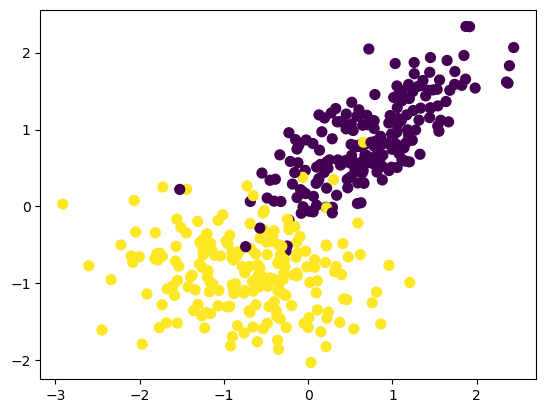

In [3]:
# データの可視化
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', s=50)
plt.show()

In [4]:
# ロジスティック回帰モデルの学習
model = LogisticRegression(penalty='l2', \
                           C = 1.0 \
                            )
model.fit(X_train, y_train)

# テストデータに対する予測
y_pred = model.predict(X_test)

# 結果の評価
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.94


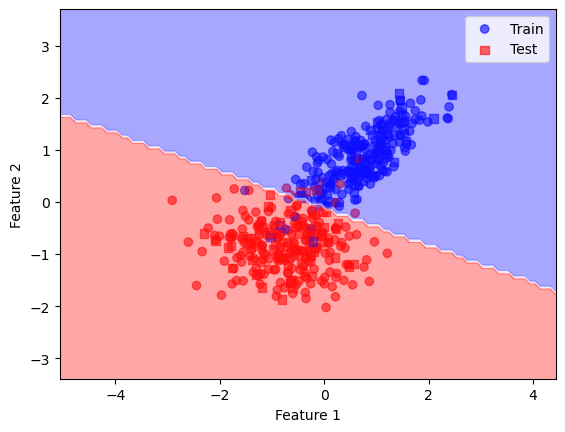

In [5]:
# 散布図の描画
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', alpha=0.6, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', alpha=0.6, marker='s', label='Test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# 決定境界の描画mu , var
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1), np.arange(x2_min, x2_max, 0.1))
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.4, cmap='bwr')

plt.show()


## ガウス過程によるベイズロジスティック回帰

関数$a(x)$の上でのガウス過程を定義する．

これをシグモイド関数$y=\sigma(a)$で変換することで，$y \in (0,1)$であるような関数$y(x)$の上での非ガウス確率過程が得られる．

以下にガウス過程からのサンプルをシグモイド関数で変換した様子を示す．

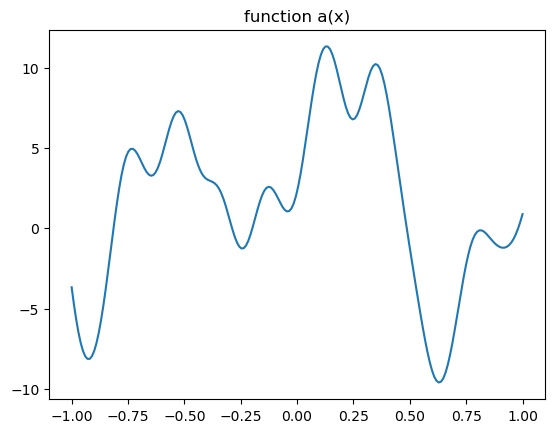

In [38]:
# ガウス過程からのサンプリング
from Gaussian_method import *
import numpy as np
import matplotlib.pyplot as plt

theta = [50.0, 100.0, 15.0, 10.0]

# 入力値
X = np.linspace(-1, 1, 200)

np.random.seed(0)
samples = sample_gp(X, theta , 2)

# プロット
plt.plot(X, samples[1])
plt.title(f'function a(x)')
plt.show()

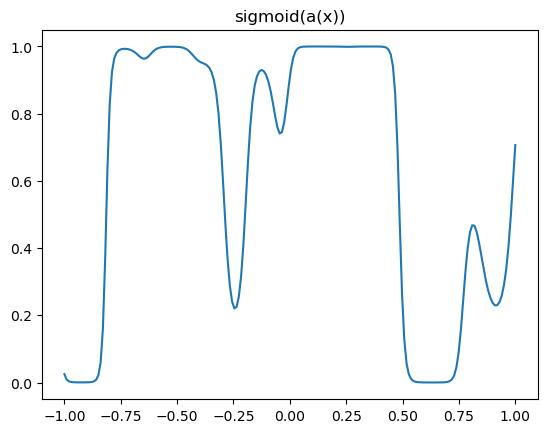

In [40]:
# シグモイド関数で変換
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

y = sigmoid(samples[1])

# プロット
plt.plot(X, y)
plt.title(f'sigmoid(a(x))')
plt.show()


目標変数$t$の確率分布はベルヌーイ分布となる．
$$
p(t | y(a(x))) = \sigma(a(x))^{t} (1 - \sigma(a(x)))^{1-t}
$$

目標は予測分布$p(t^*|t)$を決定することである．
$$
p(t^*=1|t) = \int p(t^*=1|a^*) p(a^*|t) da^* = \int \sigma(a^*) p(a^*|t) da^*
$$
この積分が解析的には不可能であるから，様々な近似手法が必要になる．

今回はビショップに習ってラプラス近似を用いる．

### ラプラス近似

$a^*$の事後分布はベイズの定理と$p(t|a^*,a)=p(t|a)$より
$$
p(a^*|t) = \int p(a^*|a,t) p(a|t) da = \int p(a^*|a) p(a|t) da
$$

期待値と分散は計算をすると
$$
\mathbb{E}[a^*|t] = k_*^T(t - \sigma(a))
$$
$$
\mathrm{var}[a^*|t] =k(x^*,x^*) - k_*^T(W^{-1} + C)^{-1} k_*
$$
ただし，$W$は$\sigma(a_n)(1-\sigma(a_n))$を対角要素とする$N \times N$の対角行列である．

以上から予測分布は
$$
p(t^*=1|t) = \int \sigma(a^*) p(a^*|t) da^* \approx \int \sigma(a^*) \mathcal{N}(a^*|\mathbb{E}[a^*|t],\mathrm{var}[a^*|t]) da^*
$$
と近似して
$$
p(t^*=1|t) \approx  \sigma(\mathbb{E}[a^*|t]\kappa(\mathrm{var}[a^*|t]))
$$
ただし，$\kappa(s^2) = \dfrac{1}{\sqrt{1+\frac{\pi s^2}{8}}}$

### EP法による近似

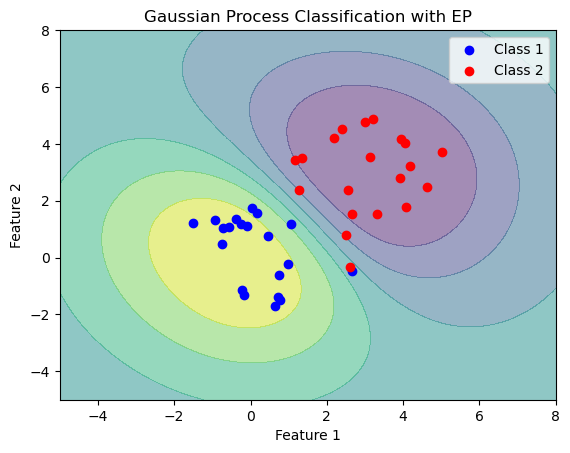

In [6]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# サンプルデータを生成します。
# クラス1のデータ
X1 = np.random.randn(20, 2)
Y1 = np.ones((20, 1))

# クラス2のデータ
X2 = np.random.randn(20, 2) + 3
Y2 = np.zeros((20, 1))

# データを結合します。
X = np.vstack((X1, X2))
Y = np.vstack((Y1, Y2))

# ガウス過程分類モデルを作成します。
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)
model = GPy.models.GPClassification(X, Y, kernel=kernel)

# EP法を使用して最適化します。
model.optimize('bfgs', max_iters=100)

# 新しいデータ点の予測を行います。
x_test = np.linspace(-5, 8, 100).reshape(-1, 1)
y_test = np.linspace(-5, 8, 100).reshape(-1, 1)
x_test_grid, y_test_grid = np.meshgrid(x_test, y_test)
X_test = np.vstack((x_test_grid.ravel(), y_test_grid.ravel())).T
probs, _ = model.predict(X_test)

# 予測をプロットします。
plt.contourf(x_test_grid, y_test_grid, probs.reshape(100, 100), alpha=0.5)
plt.scatter(X1[:, 0], X1[:, 1], c='blue', label='Class 1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='Class 2')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Process Classification with EP')
plt.show()